In [3]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"

output_fig_path = os.environ["FIGURES"] + "/07_BBO/04_BBO_chem/01_QED/"

os.makedirs(output_fig_path, exist_ok=True)

In [4]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0) + WhiteKernel(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0) + WhiteKernel(1.0))
]

In [5]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
    np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [6]:
QM9_smiles = load_smiles_dataset(QM9_path)
ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
print(len(ChEMBL_smiles))

132040
867606


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc
from tqdm import tqdm
import time

def procedure(complete_smiles_list, kernels, test_on=None):
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    output_dict = {}
    
    for kernel_tuple in kernels:
        
        output_dict[kernel_tuple[0]] = {
            "times_fit_list": [],
            "times_predict_list": [],
            "errors_list": [],
            "targets_list": [],
            "models_list": []
        }
        
        for split_id in range(10):
            
            subset_size = 10000
            train_size = 1000

            curr_dataset_smiles = complete_smiles_list[split_id*subset_size:split_id*subset_size+subset_size]

            smiles_train, smiles_test = train_test_split(curr_dataset_smiles, train_size=train_size)
            
            if test_on is not None:
                curr_smiles_test = test_on[split_id*subset_size:split_id*subset_size+subset_size]
                
                _, smiles_test = train_test_split(curr_smiles_test, train_size=train_size)
            
            kernel = kernel_tuple[1]
            model = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
            
            X_train = desc_builer.fit_transform(smiles_train)[0]
            X_test = desc_builer.fit_transform(smiles_test)[0]
            
            y_train = [qed_eval.eval_smi(smi) for smi in smiles_train]
            y_test = [qed_eval.eval_smi(smi) for smi in smiles_test]
            
            tstart = time.time()
            model.fit(X_train, y_train)
            output_dict[kernel_tuple[0]]["times_fit_list"].append(time.time() - tstart)
            
            tstart = time.time()
            y_pred = model.predict(X_test)
            output_dict[kernel_tuple[0]]["times_predict_list"].append(time.time() - tstart)
            
            output_dict[kernel_tuple[0]]["targets_list"].append(np.array(y_test))
            output_dict[kernel_tuple[0]]["errors_list"].append(np.array(y_pred) - np.array(y_test))
            output_dict[kernel_tuple[0]]["models_list"].append(model)
            
    return output_dict

In [6]:
train_QM9_test_QM9 = procedure(QM9_smiles, kernels)

  0%|          | 0/1000 [00:00<?, ?it/s]

MM program : obabel_mmff94
None


100%|██████████| 9000/9000 [00:24<00:00, 372.61it/s]


In [7]:
train_ChEMBL_test_ChEMBL = procedure(ChEMBL_smiles, kernels)

  1%|          | 6/1000 [00:00<00:16, 58.76it/s]

MM program : obabel_mmff94
None


100%|██████████| 9000/9000 [01:23<00:00, 107.80it/s]


In [8]:
train_QM9_test_ChEMBL = procedure(QM9_smiles, kernels, test_on=ChEMBL_smiles)

  2%|▏         | 18/1000 [00:00<00:05, 179.32it/s]

MM program : obabel_mmff94
None


100%|██████████| 9000/9000 [01:19<00:00, 112.91it/s]


In [9]:
train_ChEMBL_test_QM9 = procedure(ChEMBL_smiles, kernels, test_on=QM9_smiles)

  1%|          | 8/1000 [00:00<00:12, 77.26it/s]

MM program : obabel_mmff94
None


100%|██████████| 9000/9000 [00:23<00:00, 378.05it/s]


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
    

In [11]:
np.mean(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

0.031722842249719684

In [12]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

0.07678284752157981

In [13]:
np.mean(np.absolute(train_ChEMBL_test_QM9["RBF"]['errors_list']))

0.1556095993723967

In [14]:
np.mean(np.absolute(train_QM9_test_ChEMBL["RBF"]['errors_list']))

0.16643288548634183

In [15]:
np.mean(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

0.03707269367407483

In [16]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

0.10238681961521831

In [17]:
np.mean(np.absolute(train_ChEMBL_test_QM9["DotProduct"]['errors_list']))

0.4543901560166653

In [18]:
np.mean(np.absolute(train_QM9_test_ChEMBL["DotProduct"]['errors_list']))

0.2772683603716281

In [19]:
def plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL, train_QM9_test_ChEMBL, train_ChEMBL_test_QM9):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
        for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
                    (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
    
            sns.distplot(np.absolute(np.array(exp[0][t[1]]["errors_list"]).flatten()), ax=t[0], label=exp[1],
                         kde=False, bins=np.linspace(0, 0.8, 50))
#             plt.yscale("log")
            plt.xlim(0, 0.8)
            plt.legend()
            

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


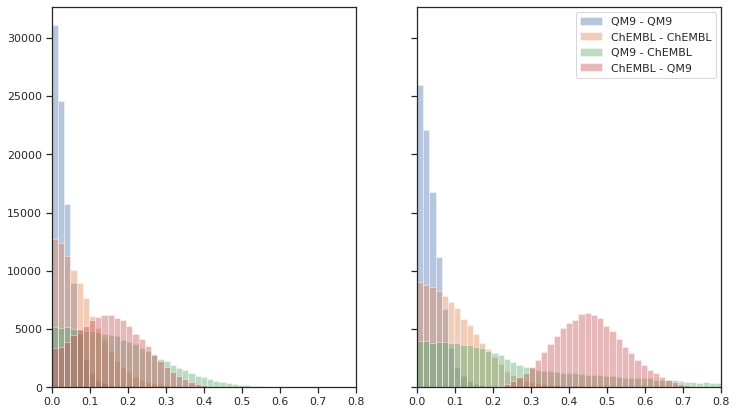

In [20]:
plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL, 
                    train_QM9_test_ChEMBL, train_ChEMBL_test_QM9)

In [21]:
def errors_vs_target(data, key):
    plt.figure(figsize=(5, 7))
    plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
                np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
                alpha=0.2, marker=',',lw=0,s=1)
    plt.plot([0, 1], [0, 1], color='g')
    plt.xlim((0, 1))

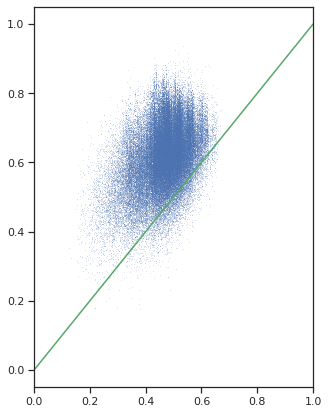

In [22]:
errors_vs_target(train_ChEMBL_test_QM9, "RBF")

In [8]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
        "ChEMBL_fit_time": [],
        "ChEMBL_predict_time": [],
        "ChEMBL_MAE": []
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
    ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_X = desc_builer.fit_transform(QM9_train_smiles)[0]
    QM9_test_X = desc_builer.fit_transform(QM9_test_smiles)[0]
    ChEMBL_train_X = desc_builer.fit_transform(ChEMBL_train_smiles)[0]
    ChEMBL_test_X = desc_builer.fit_transform(ChEMBL_test_smiles)[0]
    
    QM9_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
    ChEMBL_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
    ChEMBL_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=False)
        
        for dataset_size in dataset_sizes:
            print(dataset_size)
            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)
            
            MAE_ChEMBL, time_fit_ChEMBL, time_predict_ChEMBL = eval_model(model, ChEMBL_train_X, ChEMBL_train_y, 
                                                                          ChEMBL_test_X, ChEMBL_test_y, 
                                                                          dataset_size)
            print(time_fit_ChEMBL)
            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)
            output_dict[kernel[0]]["ChEMBL_fit_time"].append(time_fit_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_predict_time"].append(time_predict_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_MAE"].append(MAE_ChEMBL)
            
    return output_dict
            

In [ ]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [01:58<00:00, 420.92it/s]


RBF
10
0.02378559112548828
30
0.1031806468963623
100
0.43121767044067383
300
2.158332586288452
1000
17.65555763244629
3000
125.7945728302002
10000


In [1]:
def time_desc(QM9_smiles, ChEMBL_smiles):
        
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    _, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builer.fit_transform(QM9_test_smiles)
    time_QM9_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builer.fit_transform(ChEMBL_test_smiles)
    time_ChEMBL_desc = time.time() - tstart
    
    return time_QM9_desc, time_ChEMBL_desc

In [2]:
time_QM9_desc, time_ChEMBL_desc = time_desc(QM9_smiles, ChEMBL_smiles)

NameError: name 'QM9_smiles' is not defined

In [ ]:
time_QM9_desc/50

In [ ]:
time_ChEMBL_desc/50

In [ ]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc):
    
    d = {"size": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Noyau": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + time_QM9_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "ChEMBL"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["ChEMBL_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur + time_ChEMBL_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["ChEMBL_MAE"])

        
    df = pd.DataFrame.from_dict(d)

   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="size", y="MAE", hue="Données", style="Noyau", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.2)
    
    plt.savefig(join(output_fig_path, "MAE_nonorm.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="size", y="fit_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="size", y="predict_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="size", y="desc_predict_time", hue="Données", style="Noyau", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "times_nonorm.png"), dpi=250)
    
    return df

In [ ]:
plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc)

In [ ]:
output_data_efficiency